In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import random

import librosa as lbr
from librosa.display import waveplot, specshow
from librosa.feature import mfcc

import imageio
import matplotlib.image as mpimg 

import os
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
PATH = '/content/drive/My Drive/Midas_task'
CLASSES = ['disgust','fear','happy','neutral','sad']

## Plotting spectrogram 

For a few random samples from each emotion, I plot the amplitude-time graph as well a spectogram to see if there are any discernible observations pertaining to an emotion. 

Tip: Run the below code multiple times to generate the spectrogram of random audio samples.

Observation: There are no discernible features, so it is better to use MFCC for further analyses.

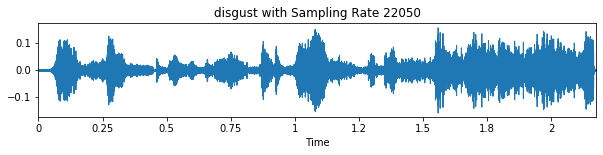

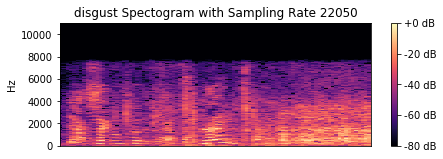

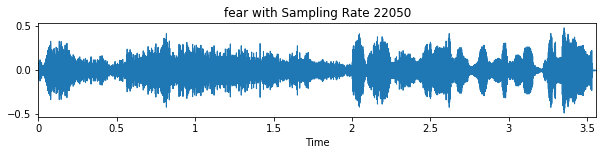

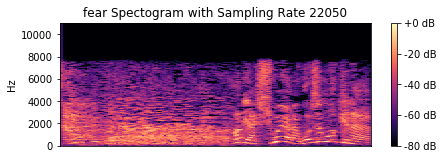

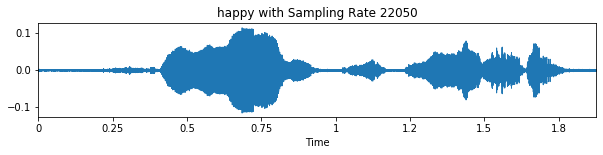

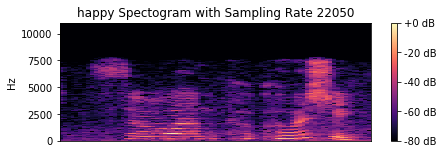

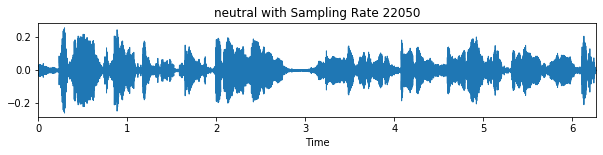

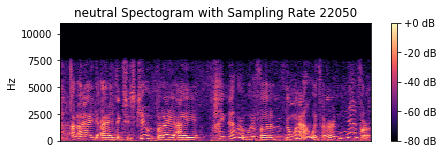

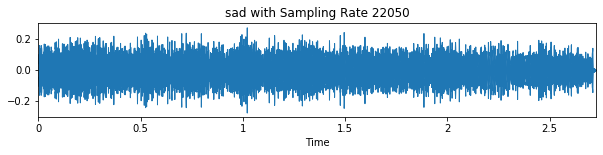

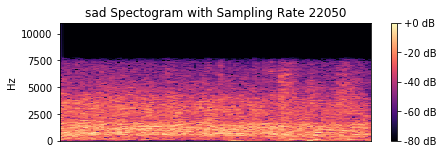

In [ ]:
count = 1

for label in CLASSES:
  
  class_path = os.path.join(PATH,'meld','train', label)
  file = random.choice(os.listdir(class_path))
  file_path = os.path.join(class_path, file)
  
  data, sr = lbr.load(file_path)
  
  plt.figure(figsize=(10,10))
  plt.subplot(5,1,count)
  lbr.display.waveplot(data,sr=sr)
  plt.title(f'{label} with Sampling Rate {sr}')
  plt.show()
  
  
  
  D = lbr.amplitude_to_db(np.abs(lbr.stft(data)), ref=np.max)
  plt.figure(figsize=(12,10))
  plt.subplot(5,2,count)
  lbr.display.specshow(D, y_axis='linear')
  plt.colorbar(format='%+2.0f dB')
  plt.title(f'{label} Spectogram with Sampling Rate {sr}')
  plt.tight_layout()
  plt.show()
  
  count = count+1
 

Converting all the examples to their image component

## Writing MFCCs

Upon noticing that spectrogram gave no visible features pertaining to each emotion i.e. one cannot discern any trends on noticing the spectrogram. I think it is better to try the state-of-the-art technique MFCC. The following attempts were made as I progressed:

#### **v1**: 
Without limiting the number of ceps, known as simple_mfcc_data, I generated the MFCC image and saved it as a jpg. Then I used a deep CNN to do image analysis. The maximum validation accuracy that I could achieve after rounds of fine tuning paramters was close to 62%. 


#### **v2**: 
Since the sequence in which the sounds occur form an integral part of what emotion it is going to be, I try to incorporate some seuquence sense into the dataset. I arrange the data in the order of time so since there are 13 cepstral coefficients into consideration per frame. The data has been arranged temporally.

This data has been written in folder mfcc_nceps13.



In [ ]:
#directories = ['train','val']
drive.mount('/content/drive') #put this because there was some mounting error(file not exist)

new_fold_name = 'mfcc_nceps13' #earlier simple_mfcc_data

train_mfcc = pd.DataFrame(columns = ['mfccs','label']);
val_mfcc = pd.DataFrame(columns = ['mfccs','label']);

location = 0; #To keep track of index

directories = ['train','val']

try: 
    os.mkdir(os.path.join(PATH,new_fold_name)) 
except OSError as error: 
    print('Printing Error',error)   
    
img_dir = os.path.join(PATH,new_fold_name);

for directory in directories:
  
  location = 0;
  
  print(f'Processing {directory}')
  
  try:
    os.mkdir(os.path.join(img_dir,directory))
  except OSError as error:
    print('Printing Error',error)
    
  for label in CLASSES:
    
    try:
      os.mkdir(os.path.join(img_dir,directory,label))
    except OSError as error:
      print('Printing Error',error);
      
    print(f'Processing {directory}/{label}');
    file_path = os.path.join(PATH,'meld',directory,label);
    #print('*******',file_path)
    for files in os.listdir(file_path):
      #print(files)
      filename = os.path.join(file_path,files);
      data,sr = lbr.load(filename);
      mfccs = mfcc(y=data,sr=sr, n_mfcc = 13);
      
      file_without_ext = os.path.splitext(os.path.basename(filename))[0]
      destination = os.path.join(img_dir,directory,label,file_without_ext+'.jpg')
      
      mfcc_reshaped = np.reshape(mfccs.T,(mfccs.shape[0]*mfccs.shape[1],1)).T
      
      print(mfcc_reshaped.shape)
      if(directory =='train'):
        train_mfcc.loc[location,'mfccs'] = mfcc_reshaped[0];
        train_mfcc.loc[location,'label'] = label;
        location=location+1;
      elif(directory =='val'):
        val_mfcc.loc[location,'mfccs'] = mfcc_reshaped[0];
        val_mfcc.loc[location,'label'] = label;
        location=location+1;
      #imageio.imwrite(destination,mfccs)

      

train_mfcc.to_csv('/content/drive/My Drive/Midas_task/mfcc_nceps13/train_mfcc.csv',index=False)

val_mfcc.to_csv('/content/drive/My Drive/Midas_task/mfcc_nceps13/val_mfcc.csv',index=False)

In [ ]:
train_mfcc.loc[455,'mfccs'].shape

(1534,)

In [ ]:
train_mfcc.to_csv('train_mfcc.csv',index=False)

val_mfcc.to_csv('val_mfcc.csv',index=False)

In [ ]:
train_df_mfcc = pd.DataFrame(train_mfcc['mfccs'].values.tolist())
train_df_label = pd.DataFrame(train_mfcc['label'])

val_df_mfcc = pd.DataFrame(val_mfcc['mfccs'].values.tolist())
val_df_label = pd.DataFrame(val_mfcc['label'])

train_data = pd.concat([train_df_mfcc,train_df_label],axis=1)
val_data = pd.concat([val_df_mfcc, val_df_label],axis=1)

'\ntrain_data = pd.concat([train_df_mfcc,train_df_label],axis=1)\nval_data = pd.concat([val_df_mfcc, val_df_label],axis=1)'

In [ ]:
train_data = pd.concat([train_df_mfcc,train_df_label],axis=1)
val_data = pd.concat([val_df_mfcc, val_df_label],axis=1)

In [ ]:
drive.mount('/content/drive') #put this because there was some mounting error(file not exist)

train_data.to_csv('/content/drive/My Drive/Midas_task/mfcc_nceps13/train_data.csv',index=False)
val_data.to_csv('/content/drive/My Drive/Midas_task/mfcc_nceps13/val_data.csv',index=False)

train_data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,131573,131574,131575,131576,131577,131578,131579,131580,131581,131582,131583,131584,131585,131586,131587,131588,131589,131590,131591,131592,131593,131594,131595,131596,131597,131598,131599,131600,131601,131602,131603,131604,131605,131606,131607,131608,131609,131610,131611,label
0,-354.225366,137.986892,-53.903279,31.576713,-26.039876,23.831565,-3.792746,-15.072373,-15.786472,11.861712,0.297376,-7.639170,5.457792,-356.751351,138.010444,-50.294047,30.177106,-25.833409,24.883032,-2.045460,-3.403461,-11.105445,11.040527,-1.073495,-12.493903,0.917682,-376.123836,129.031654,-42.651148,29.832738,-24.928046,26.235125,-5.100595,3.259192,-8.880900,1.706396,-1.181200,-8.582621,1.834749,-385.359605,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
1,-451.167700,139.604533,-4.901238,51.998616,23.200434,9.024088,-13.768832,-1.567043,7.716814,2.060671,-2.366118,-0.279964,11.456945,-422.845700,120.729808,-34.002095,63.156153,23.151365,-0.687916,-7.737725,12.407316,-1.202280,-3.267395,-6.408080,2.003277,9.645763,-370.860096,68.163665,-65.938919,96.866848,8.965965,-2.935692,-13.478839,21.135820,-10.451817,-0.345920,-5.715123,5.578192,6.646281,-300.404336,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
2,-445.058961,66.841922,-42.244241,70.327402,-22.424266,10.220212,-8.671377,16.434155,5.036451,5.483255,0.977447,-2.763261,0.107323,-441.230529,72.311656,-39.035901,68.988049,-26.597659,6.645557,-9.803852,14.613257,1.279770,1.614155,1.411975,1.207913,1.927962,-450.189106,76.222414,-36.438818,64.545528,-25.661039,6.910565,-10.159397,11.457645,1.358508,-0.168728,6.367245,3.066365,2.379443,-460.081559,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
3,-548.247056,93.181399,12.958629,17.640536,-1.539792,4.408240,8.425071,4.356407,-2.259153,1.312155,13.667447,7.957922,6.969914,-523.235865,118.765771,27.923119,20.945302,-5.364479,5.767626,6.662926,-1.850894,-4.341478,-0.643543,4.699870,0.219821,-0.790671,-436.720908,147.750736,1.369109,12.356243,-21.611128,11.973502,12.101735,-11.191833,-17.876217,-12.935160,-1.852044,0.457763,-21.052357,-357.342560,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
4,-371.185308,164.364965,-23.088533,10.368236,-7.920085,-2.181204,12.978727,4.660721,-10.970802,8.594486,5.009173,-12.443685,-6.469452,-373.259044,165.103235,-22.696948,8.597928,-8.354334,-0.130662,13.384483,4.308690,-8.708768,6.791718,4.488144,-13.438846,-7.147387,-381.279552,156.652990,-26.584594,7.843071,-12.346137,-0.700704,18.682168,1.595401,-6.545161,11.899376,1.183867,-15.249890,-7.830941,-381.043655,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,disgust
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6362,-406.520334,88.214777,3.733784,44.953465,-39.719929,38.974740,-43.884244,26.553270,-28.186879,3.340464,-5.698919,-10.187429,20.116469,-390.842125,69.542572,7.052710,56.623653,-43.939823,46.627915,-49.760073,33.755763,-32.551357,5.424553,-3.562020,-7.891101,20.608597,-411.976536,58.721664,28.663721,62.041477,-46.769225,57.171077,-53.904570,28.067951,-33.399009,10.136215,0.745401,-7.13779

In [ ]:
dff  = train_data.describe()

## Doing Image Analysis Now

In [ ]:
import random 
import shutil
import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import metrics
from keras import Sequential

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau


In [ ]:
#Copying the directory to \content directory for faster execution
!scp -r /content/drive/My\ Drive/Midas\_task/simple\_mfcc\_data .

In [ ]:
SEED=145
PATH = '/content'
TRAIN_DIR = os.path.join(PATH,'simple_mfcc_data','train')
VAL_DIR = os.path.join(PATH,'simple_mfcc_data','val')
OPT = SGD(lr=1e-3)



drive.mount('/content/drive')


class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_categorical_loss')>0.97):
            print("\nReached 97% validation accuracy so cancelling training!")
            self.model.stop_training = True



model = tf.keras.models.Sequential([
    
    tf.keras.layers.Conv2D(64, (2,2), activation='relu', input_shape=(150,150,3)),
    tf.keras.layers.MaxPooling2D((2,2)),
    #tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    #tf.keras.layers.BatchNormalization(axis=-1),
    
    tf.keras.layers.Conv2D(128,(1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    #tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(256,(1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    #tf.keras.layers.BatchNormalization(axis=-1),
    #tf.keras.layers.Dropout(0.5),
    
    tf.keras.layers.Conv2D(256,(1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    
    tf.keras.layers.Conv2D(256,(1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),

    tf.keras.layers.Conv2D(256,(1,1), activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = (2,2)),
    #tf.keras.layers.BatchNormalization(axis=-1),
    tf.keras.layers.Dropout(0.3),
    
    #tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
    #tf.keras.layers.MaxPooling2D(2,2),
    #tf.keras.layers.BatchNormalization(axis=-1),
    #tf.keras.layers.Dropout(0.3),
    
    tf.keras.layers.Flatten(),
    
    tf.keras.layers.Dense(512, activation='relu'),
    
    tf.keras.layers.Dense(5, activation='softmax')
])

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=OPT,
              metrics=['categorical_accuracy'])#,top_3_categ_acc,top_5_categ_acc])

train_datagen = ImageDataGenerator()

test_datagen = ImageDataGenerator()

# Flow training images in batches of 100 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,  # This is the source directory for training images
        target_size=(150,150),  # All images will be resized to 100x100
        batch_size=16,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=(150,150),
        batch_size=16,
        class_mode='categorical')

#Mounting unmounting
#!fusermount -u drive
#!google-drive-ocamlfuse drive
###########

model_path = os.path.join(PATH,'simple_mfcc_data','checkpointAutoSaveModel.h5')

#callbacks = myCallback()
earlyStopping = EarlyStopping(monitor='val_categorical_accuracy', patience=10, verbose=0, mode='max', restore_best_weights=True)
#modelcp_save = ModelCheckpoint(model_path, save_best_only=True, monitor='val_categorical_accuracy', mode='max')
reduce_lr_loss_on_plateau = ReduceLROnPlateau(monitor='loss', factor=0.1, patience=7, verbose=1, epsilon=1e-4, mode='min')

callback_lists = [earlyStopping, reduce_lr_loss_on_plateau ]

history = model.fit_generator(
      train_generator,
      steps_per_epoch=400,  # 6367 images = batch_size * steps
      epochs=100,
      validation_data=validation_generator,
      validation_steps=52,  # 830 images = batch_size * steps
      verbose=1,
      callbacks = callback_lists
      )

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_101 (Conv2D)          (None, 149, 149, 64)      832       
_________________________________________________________________
max_pooling2d_96 (MaxPooling (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_102 (Conv2D)          (None, 73, 73, 64)        16448     
_________________________________________________________________
max_pooling2d_97 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_103 (Conv2D)          (None, 36, 36, 128)       8320      
_________________________________________________________________
max_pooling2d_98 (MaxPooling (None, 18, 18, 128)       0

KeyboardInterrupt: ignored

In [ ]:
train_mfcc = pd.read_csv('/content/train_mfcc.csv',error_bad_lines=False)
val_mfcc = pd.read_csv('/content/val_mfcc.csv',error_bad_lines=False)

train_df_mfcc = pd.DataFrame(train_mfcc['mfccs'].values.tolist())
train_df_label = pd.DataFrame(train_mfcc['label'])

val_df_mfcc = pd.DataFrame(val_mfcc['mfccs'].values.tolist())
val_df_label = pd.DataFrame(val_mfcc['label'])

train_data = pd.concat([train_df_mfcc,train_df_label],axis=1)
val_data = pd.concat([val_df_mfcc, val_df_label],axis=1)

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()
plt.savefig(os.path.join('/content/drive/My Drive/Midas_task/simple_mfcc_data/AccPlotv1.png',,dpi=200)

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
            
            
            
model.save('/content/drive/My Drive/Midas_task/simple_mfcc_data/modelv1.h5')


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 127, 127, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 128)       7

## Doing prediction on MFCC NCeps 13 data

In [ ]:
train_path = os.path.join(PATH, 'mfcc_nceps13', 'train_data.csv')
val_path = os.path.join(PATH, 'mfcc_nceps13', 'val_data.csv')

train_data = pd.read_csv(train_path, low_memory=False, error_bad_lines = False) #had to use low_memory = False due to many features
val_data = pd.read_csv(val_path, low_memory=False,error_bad_lines = False)

#Taking only first 5000 columns

train_labels = train_data.iloc[:,-1]
val_labels = val_data.iloc[:,-1]

train_data = train_data.iloc[:,1:5000]
val_data = val_data.iloc[:,1:5000]

In [ ]:
val_data.fillna(0, inplace=True)
train_data.fillna(0, inplace=True)

from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

#One Hot encoding the label vector

lenc = LabelEncoder()
lenc.fit(train_labels)
lenc.transform(train_labels)
train_labels = to_categorical(lenc.transform(train_labels))
val_labels = to_categorical(lenc.transform(val_labels))

## Model training

v1: tried with 50 units, accuracy won't go more than 52%, Adam

v2: trying with 200 units, but won't converge, Adam

v3: 200 units, lr decreased to 0.001, Adam

v4: 300 units, lr 0.001, Adam

v5: 300 units, lr 0.0001, Adam, won't converge keeps oscillating

v6: Changed opt to SGD, stuck at 52%


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, SimpleRNN
from keras.optimizers import RMSprop, Adam, SGD

PATH = '/content/drive/My Drive/Midas_task'

import warnings
warnings.filterwarnings("ignore")

UNITS = 500 #v1 (500, too slow), v2(100,too slow)
BS = 16
EPOCHS = 20
OPT = Adam(lr=0.001)

model=Sequential();
#model.add(LSTM(UNITS, activation='tanh', recurrent_activation='sigmoid',input_shape=(1,4999)))
model.add(SimpleRNN(UNITS, activation='tanh',input_shape=(1,4999)))
model.add(Dense(5,activation='softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer = OPT, metrics=['categorical_accuracy'])

history = model.fit(train_data.values.reshape((6367,1,4999)),train_labels,batch_size=BS, epochs = EPOCHS, validation_data=(val_data.values.reshape((830,1,4999)),val_labels))

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_4 (SimpleRNN)     (None, 500)               2750000   
_________________________________________________________________
dense_44 (Dense)             (None, 5)                 2505      
Total params: 2,752,505
Trainable params: 2,752,505
Non-trainable params: 0
_________________________________________________________________
Train on 6367 samples, validate on 830 samples
Epoch 1/20
6367/6367 [==============================] - 13s 2ms/step - loss: 1.2225 - categorical_accuracy: 0.5430 - val_loss: 1.1254 - val_categorical_accuracy: 0.6217
Epoch 2/20
6367/6367 [==============================] - 7s 1ms/step - loss: 1.1868 - categorical_accuracy: 0.5580 - val_loss: 1.1049 - val_categorical_accuracy: 0.6229
Epoch 3/20
6367/6367 [==============================] - 7s 1ms/step - loss: 1.1875 - categorical_accuracy: 0.5536 - val_l

In [ ]:
model.save('/content/drive/My Drive/Midas_task/mfcc_nceps13/modelRNN.h5')

In [ ]:
model.save_weights('/content/drive/My Drive/Midas_task/mfcc_nceps13/modelRNNWeights.h5')